# Generate list of possible motifs
* Build BED for intron and upstream region
* intersect with fimo output from the entire genome for each of the 5 motif databases
* concat datasets
* take fdr of pvalues

In [1]:
import gffutils
from gffutils import pybedtools_integration
import pybedtools
from pybedtools.featurefuncs import gff2bed
import pandas as pd
import seaborn as sb
import statsmodels
import statsmodels.api as sm
%matplotlib inline

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


I first use gffutils to get introns plus 1kb upstream of transcripts:

In [2]:
db = gffutils.FeatureDB('/data/LCDB/lcdb-references/dmel/r6-11/gtf/dmel_r6-11.gtf.db')

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.5/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.7.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


- get exons, then merge them
- subtract from gene to get introns
- slop transcripts
- subtract transcripts from slopped transcripts to get just upstream
- cat slop with introns

In [3]:
exons = pybedtools_integration.to_bedtool(db.features_of_type('exon')).saveas()

In [4]:
exonmerge = exons.sort().merge().saveas('../../output/dm6_exons.bed') #need to figure this out

In [5]:
genes = pybedtools_integration.to_bedtool(db.features_of_type('gene')).saveas('../../output/dm6_genes.gtf')
genes = genes.sort().merge().saveas()

In [6]:
introns = genes.subtract(exonmerge).saveas('../../output/dm6_introns.bed')

In [7]:
transcripts = pybedtools_integration.to_bedtool(db.features_of_type('transcript')).saveas()

In [8]:
slopped = transcripts.slop(b=1000, s=True, genome='dm6').saveas()

In [9]:
diff = slopped.subtract(genes, s=False).saveas('../../output/dm6_diff.bed')

In [10]:
intslop = diff.cat(introns).saveas('../../output/dm6_intron_sloptranscript.bed')

Now I have my regions, need to intersect with fimo outputs from each database: 


# dmmpmm

Here's my parser: (only problem is its going to be slower than gff2bed for the big files, I think)

In [19]:
table = []
with open('../../motif-wf/data/fimo/motif_alignments_dmmpmm2009_dm6.gff') as f:
    for line in f: 
        if not line.startswith('##'):
            broken = line.split('\t')
            pattern = broken[8].split(';')[3]
            pval = float(broken[8].split(';')[2][7:])
            qval = float(pattern[7:].strip())
            TF = broken[8].split(';')[0][5:]
            start = broken[3]
            end = broken[4]
            chrom = broken[0]
            strand = broken[6]
            stuff = (chrom, start, end, TF, strand, pval, qval)
            table.append(stuff)
            
new_df_dmm= pd.DataFrame(table, columns=['chrom','start','end','name', 'strand', 'pvalue', 'qvalue'])

In [20]:
dmm_df = new_df_dmm[['chrom','start','end', 'name', 'strand','pvalue']]
#add column for motif_FBgn
symbolmap = pd.read_table('/data/LCDB/lcdb-references/dmel/r6-11/gtf/dmel_r6-11.SYMBOL.csv', sep=',') 
addcol = dmm_df.merge(symbolmap, left_on='name', right_on='SYMBOL', how='left')
addcol[['chrom','start','end','name','strand','pvalue','ENSEMBL']].to_csv('../../output/dmmpmm.bed', sep='\t', header=None, index=False)

In [11]:
dm_intersect = pybedtools.BedTool('../../output/dmmpmm.bed').intersect(intslop).saveas().to_dataframe()

In [12]:
dm_intersect.columns = ['chrom','start','end', 'motif_symbol','strand', 'pval','motif_FBgn']

# flyReg

In [23]:
table = []
with open('../../motif-wf/data/fimo/motif_alignments_flyReg_dm6.gff') as f:
    for line in f: 
        if not line.startswith('##'):
            broken = line.split('\t')
            pattern = broken[8].split(';')[3]
            pval = float(broken[8].split(';')[2][7:])
            qval = float(pattern[7:].strip())
            TF = broken[8].split(';')[0][5:]
            start = broken[3]
            end = broken[4]
            chrom = broken[0]
            strand = broken[6]
            stuff = (chrom, start, end, TF, strand, pval, qval)
            table.append(stuff)
            
new_df_flyReg= pd.DataFrame(table, columns=['chrom','start','end','name', 'strand', 'pvalue', 'qvalue'])

In [24]:
flyReg_df = new_df_flyReg[['chrom','start','end', 'name', 'strand','pvalue']]

In [25]:
#add column for motif_FBgn
symbolmap = pd.read_table('/data/LCDB/lcdb-references/dmel/r6-11/gtf/dmel_r6-11.SYMBOL.csv', sep=',') 
addcol = flyReg_df.merge(symbolmap, left_on='name', right_on='SYMBOL', how='left')
addcol[['chrom','start','end','name','strand','pvalue','ENSEMBL']].to_csv('../../output/flyReg.bed', sep='\t', header=None, index=False)

In [13]:
fR_intersect = pybedtools.BedTool('../../output/flyReg.bed').intersect(intslop).saveas().to_dataframe()

In [14]:
fR_intersect.columns = ['chrom','start','end', 'motif_symbol','strand', 'pval','motif_FBgn']

# idmmpmm

In [28]:
table = []
with open('../../motif-wf/data/fimo/motif_alignments_idmmpmm2009_dm6.gff') as f:
    for line in f: 
        if not line.startswith('##'):
            broken = line.split('\t')
            pattern = broken[8].split(';')[3]
            pval = float(broken[8].split(';')[2][7:])
            qval = float(pattern[7:].strip())
            TF = broken[8].split(';')[0][5:]
            start = broken[3]
            end = broken[4]
            chrom = broken[0]
            strand = broken[6]
            stuff = (chrom, start, end, TF, strand, pval, qval)
            table.append(stuff)
            
new_df_idm= pd.DataFrame(table, columns=['chrom','start','end','name', 'strand', 'pvalue', 'qvalue'])

In [29]:
idm_df = new_df_idm[['chrom','start','end', 'name', 'strand','pvalue']]
#add column for motif_FBgn 
addcol = idm_df.merge(symbolmap, left_on='name', right_on='SYMBOL', how='left')
addcol[['chrom','start','end','name','strand','pvalue','ENSEMBL']].to_csv('../../output/idm.bed', sep='\t', header=None, index=False)

In [15]:
idm_intersect = pybedtools.BedTool('../../output/idm.bed').intersect(intslop).saveas().to_dataframe()

In [16]:
idm_intersect.columns = ['chrom','start','end', 'motif_symbol','strand', 'pval','motif_FBgn']

# onTheFly

In [11]:
table = []
with open('../../motif-wf/data/fimo/motif_alignments_onTheFly_dm6.gff') as f:
    for line in f: 
        if not line.startswith('##'):
            broken = line.split('\t')
            pattern = broken[8].split(';')[3]
            pval = float(broken[8].split(';')[2][7:])
            qval = float(pattern[7:].strip())
            TF = broken[8].split(';')[0][5:]
            start = broken[3]
            end = broken[4]
            chrom = broken[0]
            strand = broken[6]
            stuff = (chrom, start, end, TF, strand, pval, qval)
            table.append(stuff)
            
new_df_oTF= pd.DataFrame(table, columns=['chrom','start','end','name', 'strand', 'pvalue', 'qvalue'])

NOTE: 
OTF0415.1 doesn't have a FBgn, and upon further inspection (https://bhapp.c2b2.columbia.edu/OnTheFly/cgi-bin/motif_entry.php?protein_ID=OTF0415.1) doesn't have any identifying information. So we're ignoring it. |

Remove OTF0415.1 entries from data: 

In [12]:
oTF_df = new_df_oTF[['chrom','start','end', 'name', 'strand','pvalue']]
#add column for motif_FBGN
otfmap = pd.read_table('../../output/onTheFlyMap.tsv')
y = otfmap[['name', 'FBgn']]
update = oTF_df.merge(y, on='name', how='left')
update = update[update.name != 'OTF0415.1']

In [13]:
#flybase annotation: 
fb = pd.read_table('/data/LCDB/lcdb-references/dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation')

In [42]:
# Make map of old fbgn to current fbgn and current fbgn to current symbol
fbgns = {}
genes = {}
for i, record in fb.iterrows():
    fbgn = record.primary_FBgn
    symbol = record.gene_symbol
    fbgn2 = record.secondary_FBgn
    
    fbgns[fbgn] = fbgn
    genes[fbgn] = symbol
    
    if isinstance(fbgn2, str):
        for f2 in fbgn2.strip().split(','):
            fbgns[f2] = fbgn

In [15]:
#update fbgn and add symbol column
update['curr_fbgn'] = update.apply(lambda x: fbgns[x.FBgn], axis=1)
update['symbol'] = update.apply(lambda x: genes[x.curr_fbgn], axis=1)

In [16]:
update[['chrom','start','end','symbol','strand','pvalue','curr_fbgn']].to_csv('../../output/oTF.bed', sep='\t', header=None, index=False)

In [17]:
oTF_intersect = pybedtools.BedTool('../../output/oTF.bed').intersect(intslop).saveas().to_dataframe()

In [18]:
oTF_intersect.columns = ['chrom','start','end', 'motif_symbol','strand', 'pval','motif_FBgn']

# flyFactor

In [34]:
table = []
with open('../../motif-wf/data/fimo/motif_alignments_flyFactor_dm6.gff') as f:
    for line in f: 
        if not line.startswith('##'):
            broken = line.split('\t')
            pattern = broken[8].split(';')[3]
            pval = float(broken[8].split(';')[2][7:])
            qval = float(pattern[7:].strip())
            TF = broken[8].split(';')[0][5:].split('_')[0]
            start = broken[3]
            end = broken[4]
            chrom = broken[0]
            strand = broken[6]
            stuff = (chrom, start, end, TF, strand, pval, qval)
            table.append(stuff)
            
new_df_fF= pd.DataFrame(table, columns=['chrom','start','end','name', 'strand', 'pvalue', 'qvalue'])

In [47]:
fF_df = new_df_fF[['chrom','start','end', 'name', 'strand','pvalue']]

In [63]:
#update fbgn and add symbol column
fF_df['curr_fbgn'] = fF_df.apply(lambda x: fbgns[x['name']], axis=1)
fF_df['symbol'] = fF_df.apply(lambda x: genes[x.curr_fbgn], axis=1)

In [66]:
fF_df[['chrom','start','end','symbol','strand','pvalue','curr_fbgn']].to_csv('../../output/fF.bed', sep='\t', header=None, index=False)


In [19]:
fF_intersect = pybedtools.BedTool('../../output/fF.bed').intersect(intslop).saveas().to_dataframe()

In [20]:
fF_intersect.columns = ['chrom','start','end', 'motif_symbol','strand', 'pval','motif_FBgn']

# Combine and drop dublicates: 
once I have all of these ``` <database>_frame``` s, do a concat. Then,
- Combine fimo datasets from all motif databases.
- Remove duplicate entries due to a TF being present in multiple databases.

In [21]:
#combine intersected dfs from all databases
concat = [dm_intersect, fR_intersect, oTF_intersect, idm_intersect, fF_intersect] 
alldatabases = pd.concat(concat)

In [25]:
alldatabases.head()

,chrom,start,end,motif_symbol,strand,pval,motif_FBgn
0,chr2L,278605,278612,bcd,+,0.000014,FBgn0000166
1,chr2L,383877,383884,bcd,+,0.000014,FBgn0000166
2,chr2L,579770,579777,bcd,+,0.000014,FBgn0000166
3,chr2L,683479,683486,bcd,+,0.000014,FBgn0000166
4,chr2L,1222849,1222856,bcd,+,0.000014,FBgn0000166


In [71]:
alldata = pybedtools.BedTool.from_dataframe(alldatabases[['chrom','start','end','motif_symbol','pval','strand','motif_FBgn']]).saveas('../../output/alldatabases.bed')

In [28]:
#alldata = pybedtools.BedTool('../../output/alldatabases.bed')

In [26]:
alldatabases.dropna(how='all', inplace=True)

In [27]:
alldatabases.shape

(23647165, 7)

In [29]:
alldatabases[alldatabases.motif_FBgn.isnull()].motif_symbol.unique()

array(['br-Z1', 'br-Z3', 'br-Z4', 'BEAF-32B', 'br-Z2', 'Cf2-II', 'dsx-F',
       'dsx-M', 'Espl', 'His2B', 'HLHm5', 'p120', 'SuH', 'suHw'], dtype=object)

In [30]:
alldatabases['motif_FBgn'] = alldatabases['motif_FBgn'].fillna('.')

In [43]:
#iterate through transciption factors and do the merge on each
done = []
done_symbol = []
for name, group in alldatabases.groupby(['motif_FBgn']):
    if name not in done: 
        done.append(name)
        if name is '.': 
            for x in group.motif_symbol:
                if x not in done_symbol: 
                    done_symbol.append(x)
                    if x == x: 
                        df = alldatabases[alldatabases.motif_symbol == x]
                    else:
                        extra = alldatabases[alldatabases.motif_FBgn == '.']
                        df = extra[extra.motif_symbol.isnull()]
                    bed = pybedtools.BedTool.from_dataframe(df)
                    merge = bed.sort().merge(c=[6,4,7], o=['min','distinct','distinct']).to_dataframe()
                    merge.to_csv('../../output/tf_merge.bed', sep='\t', header=None, index=False, mode='a')
        else:   
            df = alldatabases[alldatabases.motif_FBgn == name]
            bed = pybedtools.BedTool.from_dataframe(df)
            merge = bed.sort().merge(c=[6,4,7], o=['min','distinct','distinct']).to_dataframe()
            merge.to_csv('../../output/tf_merge.bed', sep='\t', header=None, index=False, mode='a')

In [44]:
len(done)

325

In [45]:
len(alldatabases.motif_FBgn.unique())

325

# pvalue correction! 

Calculate FDR/BF on fimo p-values

In [46]:
merged_data = pd.read_table('../../output/tf_merge.bed', header=None, names=['chrom', 'start','end','pval','motif_symbol','motif_FBgn'])
merged_data.head()

,chrom,start,end,pval,motif_symbol,motif_FBgn
0,chr2L,6782,6789,0.000036,br-Z1,.
1,chr2L,17019,17026,0.000036,br-Z1,.
2,chr2L,19846,19853,0.000036,br-Z1,.
3,chr2L,29403,29410,0.000036,br-Z1,.
4,chr2L,30047,30054,0.000036,br-Z1,.


In [47]:
merged_data['motif_symbol'] = merged_data['motif_symbol'].fillna('.')

In [48]:
#How many motif sites are there per TF?
merged_data.groupby(['motif_FBgn', 'motif_symbol']).agg({'start':['count']}).describe()

,start
,count
count,339.000000
mean,31130.200590
std,26223.012666
min,2623.000000
25%,15960.000000
50%,24541.000000
75%,39175.500000
max,302140.000000


Running the pvalue correction on the whole dataset: 
(I think we've decided not to use this method, but just in case here it is)

In [49]:
#module can be weird depending on if I run in biowulf or my comp
#Biowulf: 
#pvals_c = statsmodels.sandbox.stats.multicomp.multipletests(less_big.pval, alpha=.01, method='fdr_bh')[1]
#think this way works for both:  
pvals_c = sm.stats.multipletests(merged_data.pval.values, alpha=.01, method='fdr_bh')[1]
merged_data_copy = merged_data.copy()
merged_data_copy['FDR'] = list(pvals_c)

In [50]:
reject = sm.stats.multipletests(merged_data.pval.values, alpha=.01, method='fdr_bh')[0]

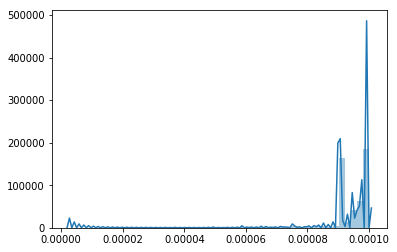

In [51]:
sb.distplot(pvals_c)

In [53]:
bonferonni = sm.stats.multipletests(merged_data.pval.values, alpha=.01, method='bonferroni')

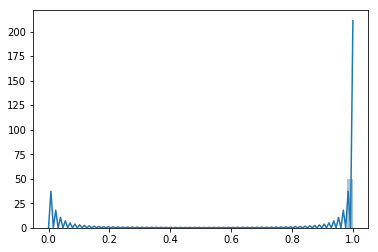

In [54]:
sb.distplot(bonferonni[1])

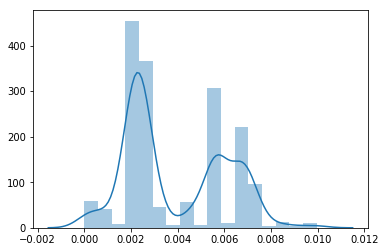

In [55]:
sb.distplot(bonferonni[1][bonferonni[0]])

In [56]:
#Calc FDR/BF by TF: 
alldone = []
for name, group in merged_data.groupby(['motif_FBgn', 'motif_symbol']):
    if name not in alldone: 
        alldone.append(name)
        df = merged_data[(merged_data.motif_FBgn == name[0]) & (merged_data.motif_symbol == name[1])]
        fdr = sm.stats.multipletests(df.pval.values, alpha=1e-4, method='fdr_bh')
        bonf = sm.stats.multipletests(df.pval.values, alpha=1e-4, method='bonferroni')
        df_copy = df.copy()
        df_copy['FDR'] = list(fdr[1])
        df_copy['FDR_sig'] = list(fdr[0])
        df_copy['BF'] = list(bonf[1])
        df_copy['BF_sig'] = list(fdr[0])
        df_copy.to_csv('../../output/pval_correction', sep='\t', header=None, index=False, mode='a')

In [2]:
pvalcorrection = pd.read_table('../../output/pval_correction', header=None, names=['chrom', 'start','end','pval','motif_symbol','motif_FBgn', 'FDR','FDR_sig','BF', 'BF_sig'])
pvalcorrection.head()

,chrom,start,end,pval,motif_symbol,motif_FBgn,FDR,FDR_sig,BF,BF_sig
0,chr2L,51600,51607,0.000052,BEAF-32B,.,0.000078,True,0.295466,True
1,chr2L,62714,62721,0.000078,BEAF-32B,.,0.000078,True,0.445770,True
2,chr2L,109803,109810,0.000052,BEAF-32B,.,0.000078,True,0.295466,True
3,chr2L,111863,111870,0.000078,BEAF-32B,.,0.000078,True,0.445770,True
4,chr2L,187464,187471,0.000078,BEAF-32B,.,0.000078,True,0.445770,True


In [3]:
pvalcorrection.FDR.describe()

count    1.055314e+07
mean     8.199635e-05
std      1.943985e-05
min      1.128498e-08
25%      7.380061e-05
50%      8.870000e-05
75%      9.645561e-05
max      1.000000e-04
Name: FDR, dtype: float64

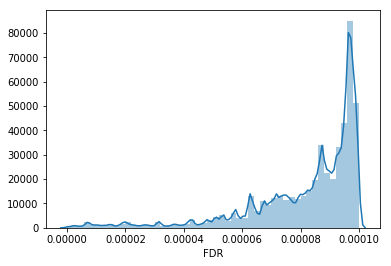

In [4]:
sb.distplot(pvalcorrection.FDR)

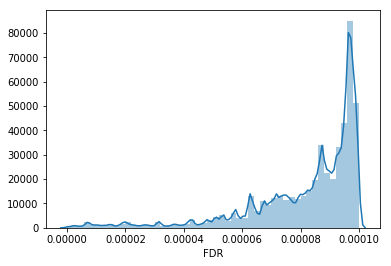

In [60]:
sb.distplot(pvalcorrection.FDR[pvalcorrection.FDR_sig])

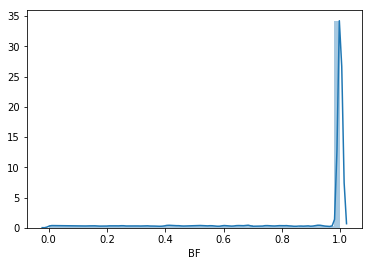

In [61]:
sb.distplot(pvalcorrection.BF)

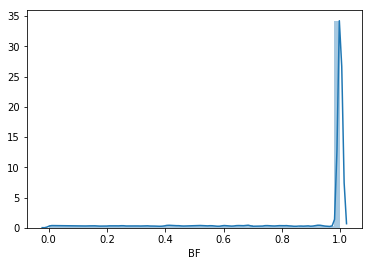

In [62]:
sb.distplot(pvalcorrection.BF[pvalcorrection.BF_sig])

In [63]:
pvalcorrection.BF.describe()

count    1.055314e+07
mean     8.367928e-01
std      2.875418e-01
min      2.785180e-08
25%      7.648720e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: BF, dtype: float64

### Intersect to gain target gene information: 

In [5]:
#put dataframe in bed format (this is unreal slow)
pvalc_bed = pybedtools.BedTool.from_dataframe(pvalcorrection)

In [6]:
gene_info = pybedtools.BedTool('../../output/dm6_genes.gtf')

In [7]:
bigintersect = pvalc_bed.intersect(gene_info, wb=True).saveas().to_dataframe()

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.5/site-packages/pybedtools/bedtool.py:3287: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 19 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


In [8]:
trim = bigintersect[[0,1,2,3,4,5,6,7,8,9,18]]

In [9]:
trim.columns = ['chrom', 'start','end','pval','motif_symbol','motif_FBgn', 'FDR','FDR_sig','BF', 'BF_sig', 'gene_info']

In [10]:
trim['gene_symbol'] = [x.split(';')[0].split()[1].strip('\"') for x in trim.gene_info]
trim['gene_FBgn'] = [x.split(';')[1].split()[1].strip('\"') for x in trim.gene_info]

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/data/bergeric/miniconda3/envs/s2rnai/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [11]:
data_wgene = trim[['chrom', 'start', 'end', 'pval', 'motif_symbol', 'motif_FBgn','gene_symbol', 'gene_FBgn', 'FDR',
       'FDR_sig', 'BF', 'BF_sig']]

In [12]:
data_wgene.shape

(9433345, 12)

### filter out the "insignificant" pvalues, keep just the significant BF
- if alpha is decreased more we lose too many motifs, but right now they all pass the filter 
- will most likely keep all for the "liberal" matrix, unless there are too many genes included

In [13]:
filtered = data_wgene[data_wgene.BF_sig == True]
len(filtered.motif_FBgn.unique())

325

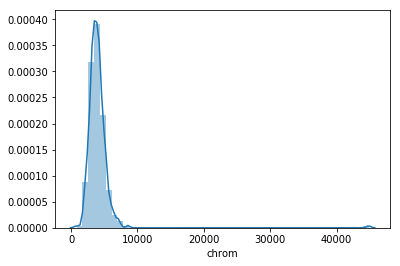

In [14]:
sb.distplot(filtered.groupby(['motif_FBgn', 'motif_symbol','gene_FBgn','gene_symbol']).count().groupby(level=0).count().chrom)

In [75]:
bob = filtered.groupby(['motif_FBgn', 'motif_symbol','gene_FBgn','gene_symbol']).count().groupby(level=0).count()

In [76]:
bob.head()

,chrom,start,end,pval,FDR,FDR_sig,BF,BF_sig
motif_FBgn,,,,,,,,
.,44825,44825,44825,44825,44825,44825,44825,44825
FBgn0000014,6030,6030,6030,6030,6030,6030,6030,6030
FBgn0000015,5250,5250,5250,5250,5250,5250,5250,5250
FBgn0000022,4016,4016,4016,4016,4016,4016,4016,4016
FBgn0000028,3828,3828,3828,3828,3828,3828,3828,3828


In [77]:
bob.reset_index()[bob.reset_index().motif_FBgn == 'FBgn0000504']

,motif_FBgn,chrom,start,end,pval,FDR,FDR_sig,BF,BF_sig
21,FBgn0000504,3838,3838,3838,3838,3838,3838,3838,3838


In [15]:
#need for (TF,gene) min pval, mean, count 
grp_agg = filtered.groupby(['motif_FBgn', 'motif_symbol','gene_FBgn','gene_symbol']).agg({'BF':['min','mean','count']})

In [16]:
grp_agg.head()

BF            \
                                                              min      mean   
motif_FBgn motif_symbol gene_FBgn           gene_symbol                       
.          BEAF-32B     28SrRNA-Psi:CR45851 FBgn0267511  0.295466  0.295466   
                        2mit                FBgn0260793  0.295466  0.345567   
                        4EHP                FBgn0053100  0.295466  0.295466   
                        5-HT1A              FBgn0004168  0.295466  0.370618   
                        5-HT1B              FBgn0263116  0.078867  0.078867   

                                                               
                                                        count  
motif_FBgn motif_symbol gene_FBgn           gene_symbol        
.          BEAF-32B     28SrRNA-Psi:CR45851 FBgn0267511     2  
                        2mit                FBgn0260793     3  
                        4EHP                FBgn0053100     3  
                        5-HT1A              FBgn0004168     2  
                        5-HT1B              FBgn0263116     1

In [17]:
grp_agg.to_csv('../../output/motif_final', sep='\t')

In [80]:
#have a few missing FBgns/isoforms: 
filtered[filtered.motif_FBgn == '.'].motif_symbol.unique()

array(['BEAF-32B', 'Cf2-II', 'Espl', 'HLHm5', 'His2B', 'SuH', 'br-Z1',
       'br-Z2', 'br-Z3', 'br-Z4', 'dsx-F', 'dsx-M', 'p120', 'suHw'], dtype=object)

### Isoforms
Could keep as they are (without FBgn) but the network model would have the account for that. Could also collapse to the gene level, keeping track of the fact that there are multiple motifs. Will discuss at meeting and come back to this. 
- BEAF-32B == BEAF-32 ?  
- Cf2-II did not come up on FlyBase
- Espl == E(spl)m8-HLH ?  
- HLHm5 == E(spl)m5-HLH ? 
- His2B is FBgn0001198
- SuH == Su(H) ? 
- br-Z1,2,3,4 == br? 
- dsx-F/M == dsx
- p120 has multiple possibilities
- suHw == su(Hw) ? 